# Ordinary Least Square Implementation

This notebook implements ordinary least square algorithm. It uses batch gradient descent algorithm to fit the model. The notebook is split into following four sections:

1. Implements support classes requried for batch gradient descent algorithm. 
2. Implements ordinary least square method. 
3. Generates 1000 randomly sampled data with 5 features. The dataset is split into training (80%) and testing (20%). Finally a model if fitted using above implementation
4. Trains a linear regression model on the above dataset using OLS implementation over here and using sklearn 

## Section 1: Matrix Classes

In [1]:
import numpy as np
import unittest

class Matrix(object):
    """
    Provides an interface to work with matrices    
    """
    
    def __init__(self, data):
        """
        constructor
        
        Keyword arguments:
        data -- a list object
        
        """
        self.__data = data
        self.__shape = None
        
    @property
    def data(self):
        """
        returns original datasets
        """
        return self.__data
        
    @property
    def shape(self):
        """returns dimension of the matrix"""
        if self.__shape == None:            
            dim = []
            counter = 0
            tmp = self.__data
            while(True):
                if isinstance(tmp, list):
                    dim.append(len(tmp))
                    tmp = tmp[0]
                else:
                    break

            self.__shape = (dim[0], ) if(len(dim) == 1) else tuple(dim)
            
        return self.__shape
    

    @property
    def transpose(self):
        "returns transpose of a matrix"
        raise NotImplemented
        
    def multiply(self, y):
        "multiplies this with the input array and returns a new matrix"
        raise NotImplemented
        
    def subtract(self, y):
        "subtract input matrix from existing matrix and returns a new matrix"
        raise NotImplemented
        
    def scalarMultiply(self, value):
        "multiply each value of matrix with the input scalar value. Returns a new matrix object"
        raise NotImplemented
    
        
    def __eq__(self, other):
        "compares two matrix. Currently it relies on underlying equality method of the input data object"
        return self.data == other.data
    
    def __ne__(self, other):
        return not self.__eq__(other)    
        
        
        
class Matrix2D(Matrix):
    """
    """
    def __init__(self, data):
        super(Matrix2D, self).__init__(data)
        if len(self.shape) > 2: 
            raise ValueError("""
            This class is designed to handle only 2D arrays.
            Input data has following shape {0}
            """.format(self.shape))
            

    
    def multiply(self, y):
        """
        Multiple two matrix 
        """
        sx = self.shape
        sy = y.shape 
        
        if isinstance(y, Matrix2D) == False:
            raise ValueError("Expect input argument to be of type Matrix2D")
        
        if (sx[1] != sy[0]):
            raise ValueError("Matrix of shape {0} and {1} cannot be multiplied".format(self.shape, y.shape))

        output = []
        for i in range(sx[0]):
            output.append([0.0] * sy[1])
            for k in range(sx[1]):
                for j in range(sy[1]):
                    output[i][j] += self.data[i][k] * y.data[k][j]
        return Matrix2D(output)

    def subtract(self, y):
        """
        Subtract y from x
        """
        output = []
        if (self.shape != y.shape):
            raise ValueError("Matrix of shape {0} and {1} cannot be subtracted".format(self.shape, y.shape))

        output = []
        rows = self.shape[0]
        cols = 1 if self.shape[1] == None else self.shape[1]
        
        for row in range(rows):
            output.append([])
            for col in range(cols):
                output[row].append(self.data[row][col] - y.data[row][col])
                
        return Matrix2D(output)

    @property
    def transpose(self):
        """
        Matrix tranpose
        """
        (rows, cols) = self.shape
        return Matrix2D([[self.data[row][col] for row in range(rows)] for col in range(cols)])

    def scalarMultiply(self, value):
        """
        Scala multiplication
        """
        (rows, cols) = self.shape
        return Matrix2D([[self.data[row][col] * value for col in range(cols)] for row in range(rows)])


class TestMatrixOperation (unittest.TestCase):
    """
    Unit test for matrix computation
    """
    
    def test_shape(self):
        self.assertEqual(Matrix2D([1]).shape, (1,))
        self.assertEqual(Matrix2D([[1],[2]]).shape, (2,1))
        self.assertEqual(Matrix2D([[1,2],[2,2]]).shape, (2,2))        
        
    def test_dot(self):
        x = Matrix2D([[1,2,3],[4,5,6]])
        y = Matrix2D([[10],[10],[10]])
        self.assertEqual(x.multiply(y), Matrix2D([[60.0], [150.0]]))
        
    def test_subtract(self):
        x = Matrix2D([[1],[2],[3]])
        y = Matrix2D([[1],[2],[3]])
        self.assertEqual(x.subtract(y), Matrix2D([[0],[0],[0]]))
        
    def test_transpose(self):
        x = Matrix2D([[1,2,3]])
        self.assertEqual(x.transpose, Matrix2D([[1],[2],[3]]))
        
    def test_scalaproduct(self):
        x = Matrix2D([[1,2,3], [4,5,4]])
        self.assertEqual(x.scalarMultiply(10), Matrix2D([[10,20,30], [40,50,40]]))
        
        
    
suite = unittest.TestLoader().loadTestsFromTestCase( TestMatrixOperation )
unittest.TextTestRunner(verbosity=1,stream=sys.stderr).run( suite )    


    

.....
----------------------------------------------------------------------
Ran 5 tests in 0.003s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Section 2: Ordinary Least Square Implmentation


In [2]:
class OrdinaryLeastSquare(object):

    def __init__(self):
        "Constructor"
        self.__reset()
        
    @property
    def intercept(self):
        "Returns intercept"
        return self.__theta.data[0][0]

    @property
    def coefficients(self):
        "Returns coefficients without intercept"
        return [self.__theta.data[i][0] for i in range(1,len(self.__theta.data))]    
    
    @property
    def loss(self):
        "Returns total loss computed at each iteration"
        return self.__loss
        
    
    def fit(self, features, target, alpha = 0.01, numIterations = 1000):
        """
        Uses batch gradient descent algorith to compute regression model. 
        Currently it implements no penalties on coefficients. 
        """
        
        # Sanity Check
        if target == None or len(target) == 0:
            raise ValueError("Expecting target to be 1d array")

        if features == None or len(features) != len(target):
            raise ValueError("Expecting arrays to be of same size")


        # Create copy of input data
        numFeatures = len(features[0])
        numSamples = len(features)
        newTarget = self.__targetMatrix(target)
        newFeatures = self.__addOneToFeatures(features)
        
        # Using batch gradient descent algorithm      
        theta = Matrix2D([[1.0] for i in range(numFeatures + 1)])
        self.__reset()
        
        for iter in range(numIterations):
            hypothesis = newFeatures.multiply(theta)
            loss = hypothesis.subtract(newTarget)
            gradient = newFeatures.transpose.multiply(loss) 
            theta = theta.subtract(gradient.scalarMultiply(alpha/numSamples))
            self.__loss.append([iter, sum([loss.data[i][0]**2 for i in range(numSamples)])])

        
        self.__theta = theta
        return


    def predict(self, features):
        "Use trained model to predict target"
        newFeatures = self.__addOneToFeatures(features)
        predictions = newFeatures.multiply(self.__theta).data
        return [predictions[i][0] for i in range(len(predictions))]
    
    def __targetMatrix(self, target):
        "Returns a new target matrix as Matrix2D object"
        return Matrix2D([[target[i]] for i in range(len(target))])
    
    def __addOneToFeatures(self, features):
        "Returns a new feature matrix with additional column at the beginning where each value is 1.0"
        numFeatures = len(features[0])
        numSamples = len(features)
        newFeatures = []
        for row in range(numSamples):
            newFeatures.append([1.0])
            for col in range(numFeatures):
                newFeatures[row].append(features[row][col])
        return Matrix2D(newFeatures)

    def __reset(self):
        "Reset all parameters"
        self.__theta = None
        self.__loss = []


## Section 3: Generate Sample Data

In [3]:
from sklearn.datasets.samples_generator import make_regression 
from scipy import stats

# Generate 1000 traning samples with 5 features
features, target = make_regression(n_samples=1000, n_features=5, n_informative=1, random_state=0, noise=35)
# split data into training and test dataset
training = (features[0:800,], target[0:800,])
test = (features[800:], target[800:])


## Section 4: Train Model

In [4]:
# Train using current implementation of OLS
ols = OrdinaryLeastSquare()
ols.fit(training[0].tolist(), training[1].tolist(), alpha = 0.03, numIterations=150)
print "Intercept = {0}".format(ols.intercept)
print "Slope = {0}".format(ols.coefficients)

Intercept = -0.524117440547
Slope = [-1.64399528386033, 12.246345714998109, -0.32411830574955397, 0.349679405197548, 0.6301585123159154]


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


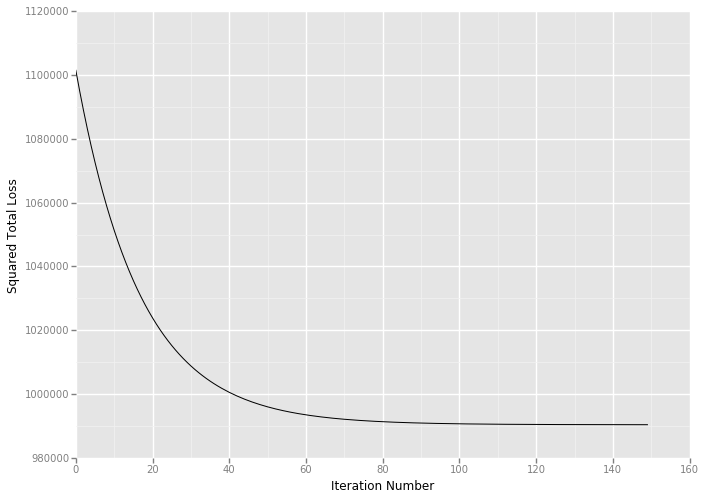

<ggplot: (285458077)>

In [5]:
# Plot total squared loss at each iteration
%matplotlib inline
import pandas as pd
from ggplot import *
df = pd.DataFrame(ols.loss, columns=["iter","loss"])
ggplot(aes(x="iter",y="loss"), data=df) + geom_line() + xlab("Iteration Number") + ylab("Squared Total Loss") 

In [141]:
# Train using sklearn
regr = linear_model.LinearRegression()
regr.fit(training[0], training[1])
print('Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

('Intercept: ', -0.50605858362401024)
('Slope: ', array([ -1.66156661,  12.3856612 ,  -0.35246313,   0.32323504,   0.61791707]))


In [146]:
data = [["Intercept", ols.intercept, regr.intercept_]]
olsCoeff = ols.coefficients
sklearnCoeff = regr.coef_
for i in range(5):
    data.append(["Coefficient {0}".format(i+1), olsCoeff[i], sklearnCoeff[i]])
coeff = pd.DataFrame(data, columns=["Coefficient","OLS","sklearn"])
coeff
                                    
    

,Coefficient,OLS,sklearn
0,Intercept,-0.524117,-0.506059
1,Coefficient 1,-1.643995,-1.661567
2,Coefficient 2,12.246346,12.385661
3,Coefficient 3,-0.324118,-0.352463
4,Coefficient 4,0.349679,0.323235
5,Coefficient 5,0.630159,0.617917
